### In this notebook, I'm going to try some witchery in order to generate a prediction of temperature from carbon and some other biogeochemical parameters.
#### First, we need to load in the .mat file of interest.
This has been handled by the script `JuliaReadMat.ipynb`, which read the `.mat` file into a Julia dataframe and then wrote it to a CSV, called `24_north.csv` (saved in this folder). We can therefore just read it into python with pandas

In [63]:
import pandas as pd
import numpy as np

alldata_24N_csv_filename = "/Users/ct6g18/Python/keras/ML_Carbon/24_north.csv"
data_24N = pd.read_csv(alldata_24N_csv_filename)

data_24N["DATE"] = data_24N["DATE"] // 10000 # No idea why this is off by ten thousand but whatever.

theta = data_24N["theta"].loc[data_24N['DATE'] < 1993]
dic   = data_24N["dic"].loc[data_24N['DATE'] < 1993]
stn   = data_24N["stn"].loc[data_24N['DATE'] < 1993]
prs   = data_24N["pressure"].loc[data_24N['DATE'] < 1993]
gam   = data_24N["gamn"].loc[data_24N['DATE'] < 1993]
lon   = data_24N["longitude"].loc[data_24N['DATE'] < 1993]
lat   = data_24N["latitude"].loc[data_24N['DATE'] < 1993]
toxy  = data_24N["toxy"].loc[data_24N['DATE'] < 1993]
NO    = data_24N["NO"].loc[data_24N['DATE'] < 1993]
PO    = data_24N["PO"].loc[data_24N['DATE'] < 1993]
date  = data_24N["DATE"].loc[data_24N['DATE'] < 1993] 
TrOCA = data_24N["canth_TrOCA_corr_umolperkg"].loc[data_24N['DATE'] < 1993]
TTD = data_24N["canth_TTD_corr_umolperkg"].loc[data_24N['DATE'] < 1993]
phi = data_24N["canth_phi_corr_umolperkg"].loc[data_24N['DATE'] < 1993]
Cstar = data_24N["canth_Cstar_corr_umolperkg"].loc[data_24N['DATE'] < 1993]

In [64]:
theta = np.asarray(theta)
dic   = np.asarray(dic)
prs   = np.asarray(prs)
gam   = np.asarray(gam)
stn   = np.asarray(stn)
lon   = np.asarray(lon)
lat   = np.asarray(lat)
NO    = np.asarray(NO)
PO    = np.asarray(PO)
TTD   = np.asarray(TTD)
TrOCA = np.asarray(TrOCA)
phi   = np.asarray(phi)
Cstar = np.asarray(Cstar)

Cnat_Cstar = dic - Cstar
Cnat_TTD = dic - TTD
Cnat_phi = dic - phi
Cnat_TrOCA = dic - TrOCA



In [65]:
idx_arr = np.random.permutation(len(theta))

theta = theta[idx_arr]
Cnat_Cstar = Cnat_Cstar[idx_arr]
Cnat_TrOCA = Cnat_TrOCA[idx_arr]
Cnat_TTD = Cnat_TTD[idx_arr]
Cnat_phi = Cnat_phi[idx_arr]
prs = prs[idx_arr]
gam = gam[idx_arr]
stn = stn[idx_arr]
lon = lon[idx_arr]
lat = lat[idx_arr]
NO = NO[idx_arr]
PO = PO[idx_arr]

data = np.asarray([theta,Cnat_Cstar,Cnat_phi,Cnat_TrOCA,Cnat_TTD,prs,lon,NO,PO]).transpose(1,0)
data = np.nan_to_num(data)

Now we're going to want to split this up into training, validation and test data.
It's a fairly small dataset so we can probably reserve 20% for testing.

In [66]:
int(np.floor(len(theta) * 0.8)) # 1812

train_targets = theta[:1812]
test_targets = theta[1812:]

train_data = data[:1812,:]
test_data = data[1812:,:]

mean_values = train_data.mean(axis=0)
std_values = train_data.std(axis=0)

train_data -= mean_values
train_data /= std_values

test_data -= mean_values
test_data /= std_values

Check this has done what we expect

In [67]:
train_data.mean(axis=0)
train_data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

Okay sweet. Now lets get on with training our model

- First lets split the training data into training and validation data

In [68]:
train_data = train_data[:1400,:]
val_data = train_data[1400:,:]

train_targets = train_targets[:1400]
val_targets = train_targets[1400:]

val_data

array([], shape=(0, 9), dtype=float64)

In [69]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64,activation='relu'
                      ,input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

model.fit(train_data,train_targets,epochs=15,batch_size=16)
val_mse,val_mae = model.evaluate(test_data,test_targets)
print(f"So the mean error is approximately {val_mae:.2f} degrees")

Epoch 1/15
 9/88 [==>...........................] - ETA: 0s - loss: 204.6025 - mae: 11.1969 

2022-10-02 14:52:07.098629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 7ms/step - loss: 153.8666 - mae: 9.3414
Epoch 2/15
88/88 [==============================] - 1s 7ms/step - loss: 8.9306 - mae: 2.0988
Epoch 3/15
88/88 [==============================] - 1s 7ms/step - loss: 1.2814 - mae: 0.6759
Epoch 4/15
88/88 [==============================] - 1s 7ms/step - loss: 0.4875 - mae: 0.4772
Epoch 5/15
88/88 [==============================] - 1s 7ms/step - loss: 0.3480 - mae: 0.4085
Epoch 6/15
88/88 [==============================] - 1s 7ms/step - loss: 0.2181 - mae: 0.3424
Epoch 7/15
88/88 [==============================] - 1s 7ms/step - loss: 0.2021 - mae: 0.3206
Epoch 8/15
88/88 [==============================] - 1s 7ms/step - loss: 0.1367 - mae: 0.2664
Epoch 9/15
88/88 [==============================] - 1s 7ms/step - loss: 0.1343 - mae: 0.2571
Epoch 10/15
88/88 [==============================] - 1s 7ms/step - loss: 0.1324 - mae: 0.2589
Epoch 11/15
88/88 [==============================] - 1s 7ms/step - loss: 0.097

2022-10-02 14:52:16.318551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [70]:
pred_theta = model.predict(test_data)
actual_theta = test_targets

2022-10-02 14:52:16.511885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Predicted Temperature from DIC, NO, PO, Pressure & Longitude')

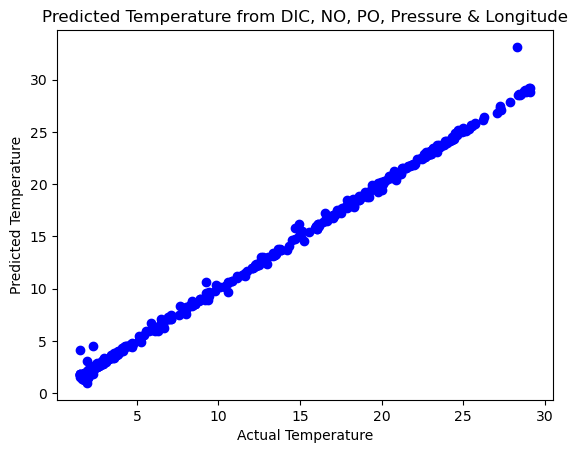

In [71]:
import matplotlib.pyplot as plt
plt.plot(actual_theta,pred_theta,'bo')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Predicted Temperature from DIC, NO, PO, Pressure & Longitude')

In [72]:
from sklearn.metrics import r2_score
TestR2Value = r2_score(actual_theta,pred_theta)
print(f"R^2 value = {TestR2Value:.4f}, ie. {100*TestR2Value:.2f}% of variance captured")

R^2 value = 0.9982, ie. 99.82% of variance captured


#### This new implementation uses the Cnat fields. 
As expected, this is has given us a larger number of 'DIC' fields but probably a 
reduced accuracy.

Anyhow, the first thing to do at this point would be to have a look at whether 
we can now us this model to predict the section temperature distribution for the
next cruise.

Text(0.5, 1.0, 'Actual Temperature')

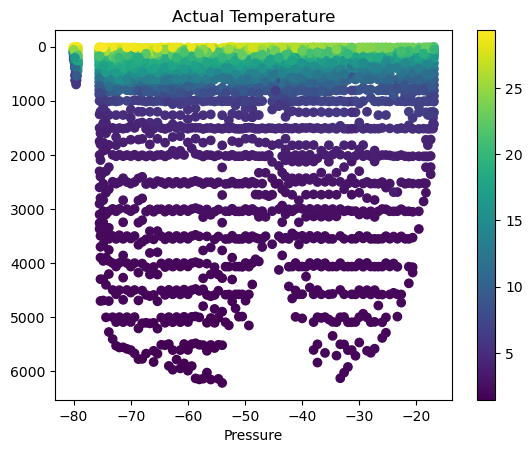

In [73]:
section = plt.scatter(lon, prs, c=theta)
# marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
ax = section.axes
plt.colorbar()
ax.invert_yaxis()
plt.xlabel("Longitude")
plt.xlabel("Pressure")
plt.title("Actual Temperature")

In [74]:
pred_theta_all = model.predict(data)
pred_theta_all

array([[26.495531 ],
       [ 2.486261 ],
       [16.765276 ],
       ...,
       [21.585861 ],
       [ 3.0928793],
       [20.40886  ]], dtype=float32)

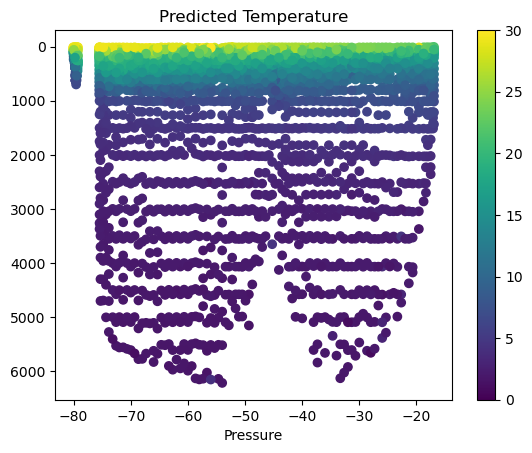

In [75]:
section = plt.scatter(lon, prs, c=pred_theta_all)
# marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
ax = section.axes
plt.colorbar()
ax.invert_yaxis()
plt.xlabel("Longitude")
plt.xlabel("Pressure")
plt.title("Predicted Temperature")
plt.clim(0,30)

In [76]:
pred_theta_all = np.squeeze(np.asarray(pred_theta_all))
theta = np.asarray(theta)
print(f'Predicted temperature shape: {pred_theta_all.shape}')
print(f'Predicted temperature shape: {theta.shape}')


Predicted temperature shape: (2266,)
Predicted temperature shape: (2266,)


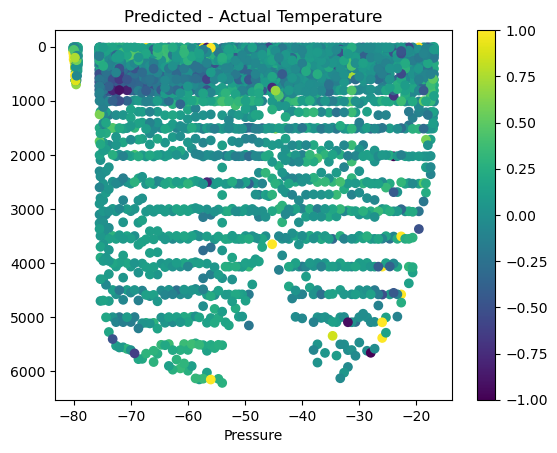

In [77]:
section = plt.scatter(lon, prs, c=pred_theta_all - theta)
# marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
ax = section.axes
plt.colorbar()
ax.invert_yaxis()
plt.xlabel("Longitude")
plt.xlabel("Pressure")
plt.title("Predicted - Actual Temperature")
plt.clim(-1,1)

Interestingly, it looks like we've actually got a model with less systematic bias when we use the `DIC - Canth` model

##### Minor notes
- Model is now noiser, but the errors look uncorrelated so we can probably smooth these out spatially somehow
- We're still getting a massive underestimate in the western boundary. Not really sure why but it's probably something to look into


# Questions to answer now:

1. Can we easily grid this using GLODAP section gridder? Intuition tells me yes, using a random exception expocode name
2. If that works, how similar does it look to the background? 

In [79]:
# I'm using G2longitude and G2pressure because I want to feed them into my 
# Julia toolbox
var_names = ["G2longitude","G2latitude","G2pressure","G2gamma","G2station","theta_actual","theta_predicted"]
var_vals = [lon,lat,prs,gam,stn,theta,pred_theta_all]

outputs = dict(zip(var_names,var_vals))
output_df = pd.DataFrame(outputs)

output_df.to_csv("pred_theta_for_gridding.csv")
